In [1]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

**Load the dataset**

In [2]:
multiclass = pd.read_csv('../../dataset/multiclass_dataset_no_weird_obs.csv',header= 0)

In [3]:
data1, data2 =  train_test_split(multiclass, test_size=0.4, random_state=42,
                                              shuffle=True, stratify=None)
train1, test1  = train_test_split(data1, test_size=0.2, random_state=46,
                                              shuffle=True, stratify=None)
train2, test2  = train_test_split(data2, test_size=0.2, random_state=39,
                                              shuffle=True, stratify=None)

In [4]:
X_test = np.array(test1.drop(['label','DepMap_ID','Unnamed: 0'], axis = 1))
y_test = pd.get_dummies(test1, columns = ['label']).iloc[:,17395:17404]
X_train = np.array(train1.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1))
y_train = pd.get_dummies(train1, columns = ['label']).iloc[:,17395:17404]

In [5]:
np.shape(X_train)

(483, 17393)

In [6]:
X_train_reshaped = X_train.reshape(483,17393)
X_test_reshaped = X_test.reshape(121,17393)

**First model**

In [7]:
model = Sequential()

model.add(Dense(200, input_shape=(17393,)))
model.add(Activation('relu'))
#model.add(Dropout(0.25))


model.add(Dense(9))
model.add(Activation('softmax'))
#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy']) #ottimizzatore che usa stochastic gradient , errore assoluto medio

early_stopping_monitor = EarlyStopping(patience= 5, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model0.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =30,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))

#in multiclass possiamo aggiungere la softmax come activation function in modo da aumentare la probabilità che solo
#un nodo di uscita venga scelto ogni volta
#se per caso due possibili risultati sono anche parzialmente sovrapponibili si usa come activation function sigmoid

Epoch 1/30
14/16 [=========================>....] - ETA: 0s - loss: 4.0001 - accuracy: 0.1763
Epoch 00001: saving model to best_model0.hdf5
16/16 [==============================] - 1s 29ms/step - loss: 3.8622 - accuracy: 0.1781 - val_loss: 2.3810 - val_accuracy: 0.1240
Epoch 2/30
13/16 [=======================>......] - ETA: 0s - loss: 1.9139 - accuracy: 0.3606
Epoch 00002: saving model to best_model0.hdf5
16/16 [==============================] - 0s 18ms/step - loss: 1.8588 - accuracy: 0.3747 - val_loss: 1.9155 - val_accuracy: 0.2810
Epoch 3/30
13/16 [=======================>......] - ETA: 0s - loss: 1.6332 - accuracy: 0.4351
Epoch 00003: saving model to best_model0.hdf5
16/16 [==============================] - 0s 19ms/step - loss: 1.6191 - accuracy: 0.4431 - val_loss: 1.6525 - val_accuracy: 0.4711
Epoch 4/30
13/16 [=======================>......] - ETA: 0s - loss: 1.3561 - accuracy: 0.5673
Epoch 00004: saving model to best_model0.hdf5
16/16 [==============================] - 0s 18ms/s

**More complex model: increase width and depth**

In [8]:
model = Sequential()

#1°layer
model.add(Dense(600, input_shape=(17393,)))
model.add(Activation('relu'))
#model.add(Dropout(0.25))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#3°layer
model.add(Dense(9))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy']) #ottimizzatore che usa stochastic gradient , errore assoluto medio

early_stopping_monitor = EarlyStopping(patience= 15, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model1.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =30,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/30
15/16 [===========================>..] - ETA: 0s - loss: 4.7610 - accuracy: 0.1063
Epoch 00001: val_accuracy improved from -inf to 0.23140, saving model to best_model1.hdf5
16/16 [==============================] - 1s 59ms/step - loss: 4.7517 - accuracy: 0.1056 - val_loss: 2.7604 - val_accuracy: 0.2314
Epoch 2/30
15/16 [===========================>..] - ETA: 0s - loss: 2.4915 - accuracy: 0.2062
Epoch 00002: val_accuracy did not improve from 0.23140
16/16 [==============================] - 1s 38ms/step - loss: 2.4908 - accuracy: 0.2050 - val_loss: 2.0035 - val_accuracy: 0.2149
Epoch 3/30
15/16 [===========================>..] - ETA: 0s - loss: 1.9444 - accuracy: 0.2979
Epoch 00003: val_accuracy improved from 0.23140 to 0.47934, saving model to best_model1.hdf5
16/16 [==============================] - 1s 55ms/step - loss: 1.9429 - accuracy: 0.3002 - val_loss: 1.7904 - val_accuracy: 0.4793
Epoch 4/30
15/16 [===========================>..] - ETA: 0s - loss: 1.6591 - accuracy: 0.4

**Performance on test**

In [23]:
#Create the vectors that contains the Cancers chosen (Cancer_Type2) and the one observed (Cancer_Type)
Cancer_Type = ["Gastrointestinal","Genitals","Muscle-Bone","Neuro","Breast","Head_Neck","Blood",
               "Genitourinary", "Lung"] 


- Eye: 0

- Gastrointestinal: 1

- Genitals: 2

- Muscle-Bone: 3

- Neuro: 4

- Breast: 5

- Head_Neck: 6

- Blood: 7

- Urinario: 8

- Lung: 9

In [27]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

In [51]:
best_model1 = load_model('best_model1.hdf5')
y_pred = np.argmax(best_model1.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(9)).T.fillna(0)

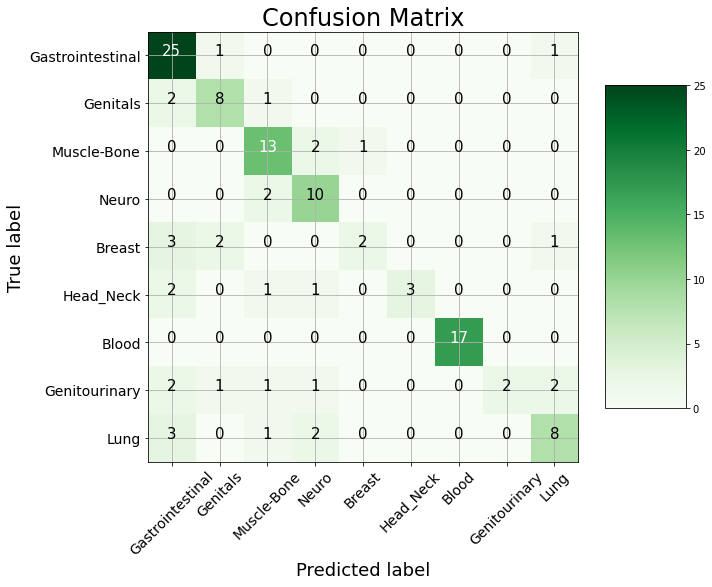

In [52]:
#Change the name of the coloumns of the class matrix created through get_dummies 
# using more meaningful names
y_pred = y_pred.set_axis(Cancer_Type, axis= 1)
y_pred = np.argmax(best_model1.predict(X_test_reshaped),axis = 1)
y_test_confusion = test1.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')


In [53]:
average_recall = 0
for i in range(8):
    average_recall += cm[i,i]/sum(cm[:,i])
    
average_recall/9

0.7020243928138665

**Try the same but with focal loss**

![Focal loss](https://lh4.googleusercontent.com/_Zb8VyevBHbPdlPS1Bcph18b0GnRdY__yrSWaxEobHAOSq5izCVXdRS0Eo-26pU5Q8JE2daQAmFlwwUKnRiaf7JJrv7VJOLXbTOF-B6G8yshVWdBwhRXFBuMB5L6eH7KCTjzen-t7e39pxku5A)

In [13]:

def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [14]:
model = Sequential()

#1°layer
model.add(Dense(400, input_shape=(17393,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#3°layer
model.add(Dense(9))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', metrics=['accuracy'], 
    loss=[categorical_focal_loss(alpha=[.25, .25, .25, .25, .25, .25, .25, .25, .25], gamma=2)])

early_stopping_monitor = EarlyStopping(patience= 15, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model_2.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =50,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 0.7535 - accuracy: 0.1312
Epoch 00001: val_accuracy improved from -inf to 0.17355, saving model to best_model_2.hdf5
16/16 [==============================] - 1s 44ms/step - loss: 0.7505 - accuracy: 0.1346 - val_loss: 0.4263 - val_accuracy: 0.1736
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.2402
Epoch 00002: val_accuracy improved from 0.17355 to 0.33058, saving model to best_model_2.hdf5
16/16 [==============================] - 1s 37ms/step - loss: 0.4157 - accuracy: 0.2402 - val_loss: 0.3855 - val_accuracy: 0.3306
Epoch 3/50
15/16 [===========================>..] - ETA: 0s - loss: 0.3434 - accuracy: 0.3208
Epoch 00003: val_accuracy did not improve from 0.33058
16/16 [==============================] - 0s 28ms/step - loss: 0.3440 - accuracy: 0.3188 - val_loss: 0.3435 - val_accuracy: 0.3058
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0

In [48]:
best_model_2 = load_model('best_model_2.hdf5', compile=False)
y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(9)).T.fillna(0)

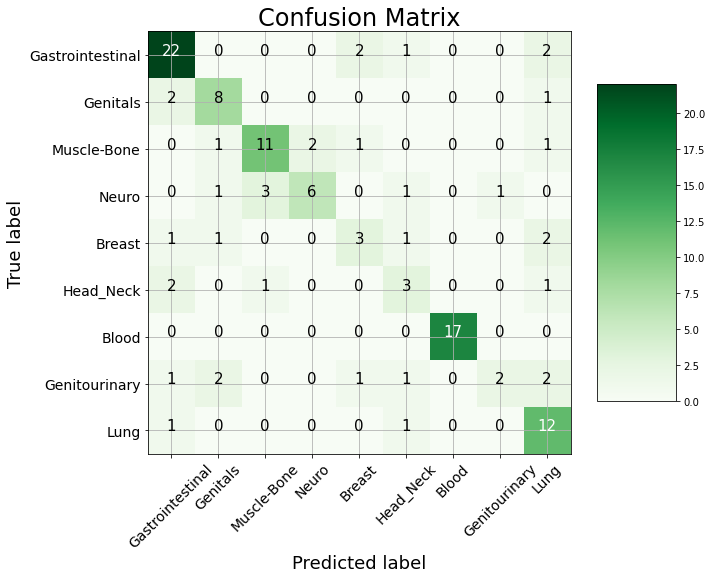

In [49]:
#Change the name of the coloumns of the class matrix created through get_dummies 
# using more meaningful names
y_test = y_test.set_axis(Cancer_Type, axis = 1)
y_pred = y_pred.set_axis(Cancer_Type, axis= 1)
y_train = y_train.set_axis(Cancer_Type, axis= 1)

y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_test_confusion = test1.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')




In [50]:
accuracy = 0
for i in range(8):
    accuracy += cm[i,i]/sum(cm[:,i])
    
accuracy/9

0.5919529704012462

**Try the same but adjust alpha paramter wrt class percentage**

In [17]:
n_obs = cm.sum(axis=1)
class_perc = n_obs/sum(n_obs)

In [18]:
model = Sequential()

#1°layer
model.add(Dense(500, input_shape=(17393,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.1))

#3°layer
model.add(Dense(9))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', metrics=['accuracy'], 
    loss=[categorical_focal_loss(alpha=class_perc, gamma=2)])

early_stopping_monitor = EarlyStopping(patience= 15, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model_3.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =50,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 0.4539 - accuracy: 0.1583
Epoch 00001: val_accuracy improved from -inf to 0.25620, saving model to best_model_3.hdf5
16/16 [==============================] - 1s 58ms/step - loss: 0.4531 - accuracy: 0.1594 - val_loss: 0.2031 - val_accuracy: 0.2562
Epoch 2/50
15/16 [===========================>..] - ETA: 0s - loss: 0.1875 - accuracy: 0.2667
Epoch 00002: val_accuracy improved from 0.25620 to 0.46281, saving model to best_model_3.hdf5
16/16 [==============================] - 1s 47ms/step - loss: 0.1872 - accuracy: 0.2671 - val_loss: 0.1356 - val_accuracy: 0.4628
Epoch 3/50
15/16 [===========================>..] - ETA: 0s - loss: 0.1469 - accuracy: 0.3021
Epoch 00003: val_accuracy improved from 0.46281 to 0.51240, saving model to best_model_3.hdf5
16/16 [==============================] - 1s 49ms/step - loss: 0.1465 - accuracy: 0.3043 - val_loss: 0.1343 - val_accuracy: 0.5124
Epoch 4/50
15/16 [===========================>..]

15/16 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 0.9937
Epoch 00029: val_accuracy did not improve from 0.70248
16/16 [==============================] - 1s 32ms/step - loss: 0.0015 - accuracy: 0.9938 - val_loss: 0.0663 - val_accuracy: 0.6777


In [45]:
best_model_3 = load_model('best_model_3.hdf5', compile=False)
y_pred = np.argmax(best_model_3.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(9)).T.fillna(0)

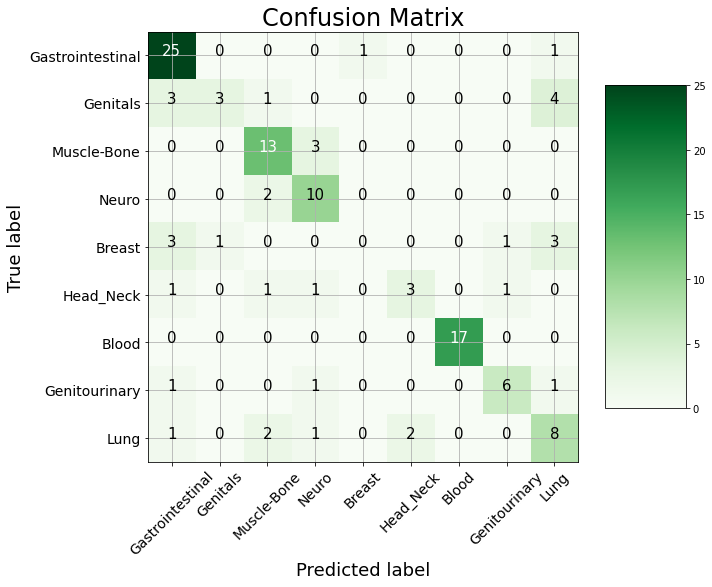

In [46]:
#Change the name of the coloumns of the class matrix created through get_dummies 
# using more meaningful names
y_pred = y_pred.set_axis(Cancer_Type, axis= 1)

y_pred = np.argmax(best_model_3.predict(X_test_reshaped),axis = 1)
y_test_confusion = test1.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')




No change at all :(

In [47]:
accuracy = 0
for i in range(8):
    accuracy += cm[i,i]/sum(cm[:,i])
    
accuracy/9

0.5716116271069832

### Now let us analyze our model using the first 1700 feature found with Holden on R

In [12]:
holden = multiclass = pd.read_csv('../../dataset/Holden.csv',header= 0)
holden = holden.iloc[0:1700]

In [13]:
test2_holden = test2.filter(holden['x_names'], axis = 1)
train2_holden = train2.filter(holden['x_names'], axis = 1)

In [14]:
X_test2 = np.array(test2_holden)
y_test2 = pd.get_dummies(test2, columns = ['label']).iloc[:,17395:17404]
X_train2 = np.array(train2_holden)
y_train2 = pd.get_dummies(train2, columns = ['label']).iloc[:,17395:17404]

In [15]:
np.shape(X_test2)

(81, 1700)

In [16]:
X_train_reshaped2 = X_train2.reshape(322,1700)
X_test_reshaped2 = X_test2.reshape(81,1700)

In [19]:
model = Sequential()

#1°layer
model.add(Dense(600, input_shape=(1700,)))
model.add(Activation('relu'))
#model.add(Dropout(0.25))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#3°layer
model.add(Dense(9))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy']) #ottimizzatore che usa stochastic gradient , errore assoluto medio

early_stopping_monitor = EarlyStopping(patience= 20, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model1.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)

hystory = model.fit(X_train_reshaped2, y_train2,
         validation_data = (X_test_reshaped2,y_test2),
                    epochs =100,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/100
 9/11 [=======================>......] - ETA: 0s - loss: 2.2988 - accuracy: 0.1597
Epoch 00001: val_accuracy improved from -inf to 0.23457, saving model to best_model1.hdf5
11/11 [==============================] - 1s 23ms/step - loss: 2.2685 - accuracy: 0.1708 - val_loss: 2.0658 - val_accuracy: 0.2346
Epoch 2/100
 9/11 [=======================>......] - ETA: 0s - loss: 2.1531 - accuracy: 0.2118
Epoch 00002: val_accuracy did not improve from 0.23457
11/11 [==============================] - 0s 9ms/step - loss: 2.1635 - accuracy: 0.1925 - val_loss: 2.0065 - val_accuracy: 0.2346
Epoch 3/100
 9/11 [=======================>......] - ETA: 0s - loss: 2.0230 - accuracy: 0.2639
Epoch 00003: val_accuracy did not improve from 0.23457
11/11 [==============================] - 0s 9ms/step - loss: 2.0132 - accuracy: 0.2764 - val_loss: 1.9616 - val_accuracy: 0.2346
Epoch 4/100
10/11 [==========================>...] - ETA: 0s - loss: 1.9367 - accuracy: 0.3094
Epoch 00004: val_accuracy improv

11/11 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9627
Epoch 00029: val_accuracy did not improve from 0.58025
11/11 [==============================] - 0s 8ms/step - loss: 0.2056 - accuracy: 0.9627 - val_loss: 1.7956 - val_accuracy: 0.4321
Epoch 30/100
10/11 [==========================>...] - ETA: 0s - loss: 0.3955 - accuracy: 0.8594
Epoch 00030: val_accuracy did not improve from 0.58025
11/11 [==============================] - 0s 8ms/step - loss: 0.3931 - accuracy: 0.8602 - val_loss: 2.0743 - val_accuracy: 0.3457
Epoch 31/100
11/11 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9783
Epoch 00031: val_accuracy did not improve from 0.58025
11/11 [==============================] - 0s 8ms/step - loss: 0.1859 - accuracy: 0.9783 - val_loss: 1.6256 - val_accuracy: 0.5062
Epoch 32/100
11/11 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9845
Epoch 00032: val_accuracy did not improve from 0.58025
11/11 [===============

In [28]:
best_model_4 = load_model('best_model4.hdf5', compile=False)
y_pred = np.argmax(best_model_4.predict(X_test_reshaped2),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(9)).T.fillna(0)

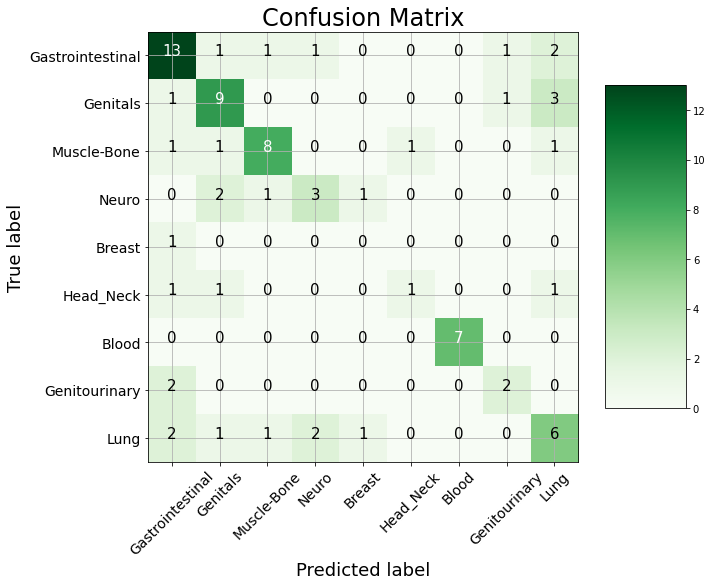

In [29]:
#Change the name of the coloumns of the class matrix created through get_dummies 
# using more meaningful names
y_pred = y_pred.set_axis(Cancer_Type, axis= 1)

y_pred = np.argmax(best_model_4.predict(X_test_reshaped2),axis = 1)
y_test_confusion = test2.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')


In [30]:
accuracy = 0
for i in range(8):
    accuracy += cm[i,i]/sum(cm[:,i])
    
accuracy/9

0.49403559403559405